In [59]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, RandomRotation, RandomAffine

In [2]:
data_files = ['/kaggle/input/ml-assignment-1/DL-Project/data0.npy', '/kaggle/input/ml-assignment-1/DL-Project/data1.npy', '/kaggle/input/ml-assignment-1/DL-Project/data2.npy']
label_files = ['/kaggle/input/ml-assignment-1/DL-Project/lab0.npy', '/kaggle/input/ml-assignment-1/DL-Project/lab1.npy', '/kaggle/input/ml-assignment-1/DL-Project/lab2.npy']


In [3]:
# Load and concatenate all data and labels
try:
    data = np.concatenate([np.load(file) for file in data_files], axis=0)
    labels = np.concatenate([np.load(file) for file in label_files], axis=0)
    
    # Display the shapes of the combined arrays for verification
    data_shape = data.shape
    labels_shape = labels.shape
    
    (data_shape, labels_shape)
except Exception as e:
    str(e)

In [4]:
data_shape, labels_shape

((30000, 40, 168), (30000,))

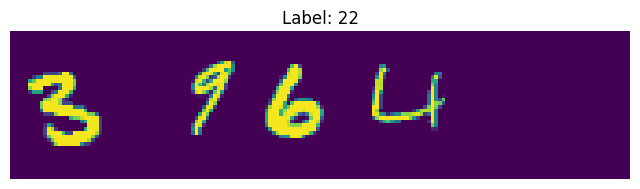

In [6]:
import matplotlib.pyplot as plt

# Function to visualize a sample from the dataset
def visualize_sample(index, data, labels):
    plt.figure(figsize=(8, 4))
    plt.imshow(data[index], cmap='viridis')
    plt.title(f"Label: {labels[index]}")
    plt.axis('off')
    plt.show()

# Visualizing a specific sample
sample_index = 47  # Same as the example in the screenshot
visualize_sample(sample_index, data, labels)


In [70]:
# Fix the CustomDataset class to keep images as 1-channel (grayscale)
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Reshape data to (1, H, W) for single grayscale channel
        image = self.data[idx].astype(np.float32).reshape(40, 168)

        label = self.labels[idx]

        # Convert to PyTorch Tensor and apply transformations
        if self.transform:
            # image = torch.tensor(image)  # Convert to PyTorch Tensor
            image = self.transform(image)

        return image, label

In [71]:
# # Data augmentation and normalization
# transform = Compose([
#     transform.ToPILImage(),
#     Resize((224, 224)),  # Resize to match ResNet input
#     RandomHorizontalFlip(p=0.5),  # Random horizontal flip
#     RandomRotation(degrees=15),  # Random rotation within 15 degrees
#     RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
#     ToTensor(),  # Convert to tensor
#     Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
# ])

In [72]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert ndarray to PIL Image
    transforms.Resize((224, 224)),  # Resize for ResNet
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])


In [61]:
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize for ResNet
#     ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
# ])


In [74]:
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [85]:
# Split dataset for training, validation, and testing
train_data = CustomDataset(data[:20000], labels[:20000], transform=transform)
val_data = CustomDataset(data[20000:24000], labels[20000:24000], transform=val_transform)
test_data = CustomDataset(data[24000:], labels[24000:], transform=None)


In [76]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [77]:


# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


# Modify the final layer for your dataset's number of classes
num_classes = len(set(labels))  # Replace with the number of unique labels


model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [78]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR after every 5 epochs


In [79]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_val_acc = 0
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        scheduler.step()

        # Print metrics
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")


In [80]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

# Test the model (use your test_loader)
# test_model(model, test_loader)



Epoch 1/10, Train Loss: 1899.3987, Train Acc: 0.0784, Val Loss: 347.7503, Val Acc: 0.1025
Epoch 2/10, Train Loss: 1714.3508, Train Acc: 0.1018, Val Loss: 324.1084, Val Acc: 0.1258
Epoch 3/10, Train Loss: 1618.9104, Train Acc: 0.1205, Val Loss: 376.2590, Val Acc: 0.0798
Epoch 4/10, Train Loss: 1541.5417, Train Acc: 0.1442, Val Loss: 288.5971, Val Acc: 0.1585
Epoch 5/10, Train Loss: 1474.5610, Train Acc: 0.1555, Val Loss: 457.6215, Val Acc: 0.0600
Epoch 6/10, Train Loss: 1350.6378, Train Acc: 0.2092, Val Loss: 244.2438, Val Acc: 0.2652
Epoch 7/10, Train Loss: 1309.5229, Train Acc: 0.2246, Val Loss: 238.5943, Val Acc: 0.2835
Epoch 8/10, Train Loss: 1273.7992, Train Acc: 0.2379, Val Loss: 234.5870, Val Acc: 0.2878
Epoch 9/10, Train Loss: 1248.0308, Train Acc: 0.2513, Val Loss: 228.4536, Val Acc: 0.3165
Epoch 10/10, Train Loss: 1226.4635, Train Acc: 0.2726, Val Loss: 224.8427, Val Acc: 0.3145
Best Validation Accuracy: 0.3165


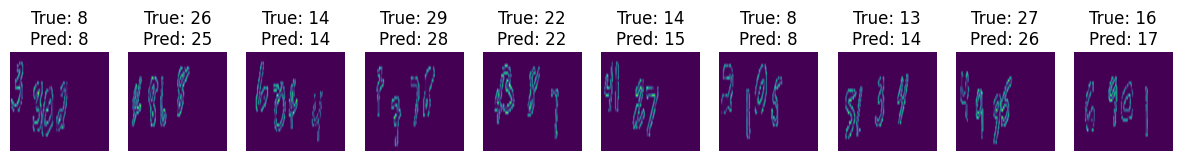

In [86]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Ensure device compatibility
    
    images, true_labels, predicted_labels = [], [], []
    
    with torch.no_grad():
        for images_batch, labels_batch in test_loader:
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            outputs = model(images_batch)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect predictions and actual labels
            images.extend(images_batch.cpu().numpy())
            true_labels.extend(labels_batch.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            
            # Stop after collecting enough samples
            if len(images) >= num_samples:
                break

    # Visualize the first `num_samples` images
    images = images[:num_samples]
    true_labels = true_labels[:num_samples]
    predicted_labels = predicted_labels[:num_samples]
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i][0], cmap='viridis')  # Show the first channel (grayscale)
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Call the visualization function
visualize_predictions(model, test_loader, num_samples=10)


In [95]:
# Save the model's state dictionary
torch.save(model.state_dict(), "resnet_model.pth")


In [97]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load the model architecture
model = models.resnet18(pretrained=False)  # Load ResNet18 architecture
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Update for 1-channel input
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Update the final layer for the number of classes

# Load the saved state dictionary
model.load_state_dict(torch.load("/kaggle/working/resnet_model.pth"))

# Set the model to evaluation mode
model.eval()


<ipython-input-97-3165c1d4584f>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/resnet_model.pth"))


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
# # Assuming `test_loader` is prepared
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # Perform inference
# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         outputs = model(images)
#         predictions = torch.argmax(outputs, dim=1)
#         print("Predictions:", predictions.cpu().numpy())
#         print("True Labels:", labels.numpy())
#         break  # Stop after the first batch
